# Convolutional Autoencoders

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 375.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.3 MB/s eta 0

In [2]:
# Import libraries
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary
from torch_snippets import *

from sklearn.manifold import TSNE

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Tue Mar 26 01:17:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Set up a normalization transform for the images
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [5]:
# Create train and validation datasets
train_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 128):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

100%|██████████| 9912422/9912422 [00:00<00:00, 86222316.51it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23228320.96it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48677750.46it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4019946.99it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [6]:
# Create a class for the Convolutional AutoEncoder model
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True), # 1 channel input, 32 channel output
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True), # 32 channel input, 64 channel output
            nn.MaxPool2d(2, stride=1))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Create a mock-up model and print summary
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(1, 1, 28, 28).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [8]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()
    return loss

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    output = model(data)
    return criterion(output, data) # Return the loss

EPOCH: 1.000  val_loss: 0.223  train_loss: 0.440  (33.16s - 132.66s remaining)
EPOCH: 2.000  val_loss: 0.100  train_loss: 0.137  (54.10s - 81.16s remaining)
EPOCH: 3.000  val_loss: 0.079  train_loss: 0.089  (75.05s - 50.03s remaining)
EPOCH: 4.000  val_loss: 0.072  train_loss: 0.077  (95.94s - 23.99s remaining)
EPOCH: 5.000  val_loss: 0.067  train_loss: 0.071  (118.08s - 0.00s remaining)


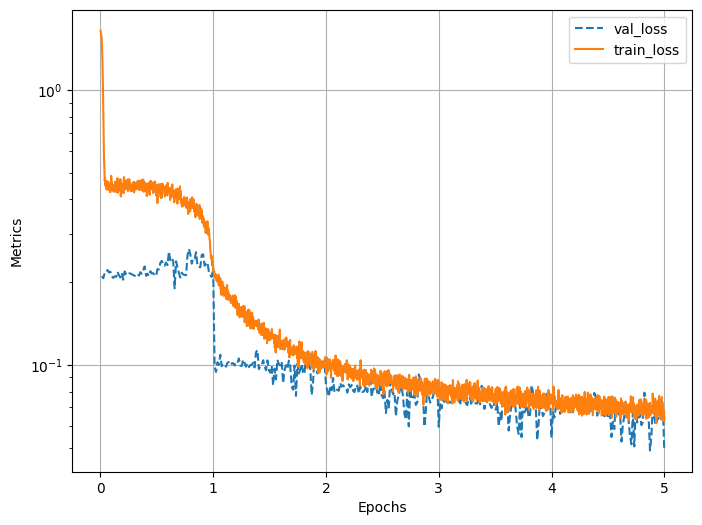

In [9]:
# Train the model
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
train_dl, val_dl = load_data()
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, (data, _) in enumerate(train_dl):
        loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, end='\r')

    n = len(val_dl)
    for i, (data, _) in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

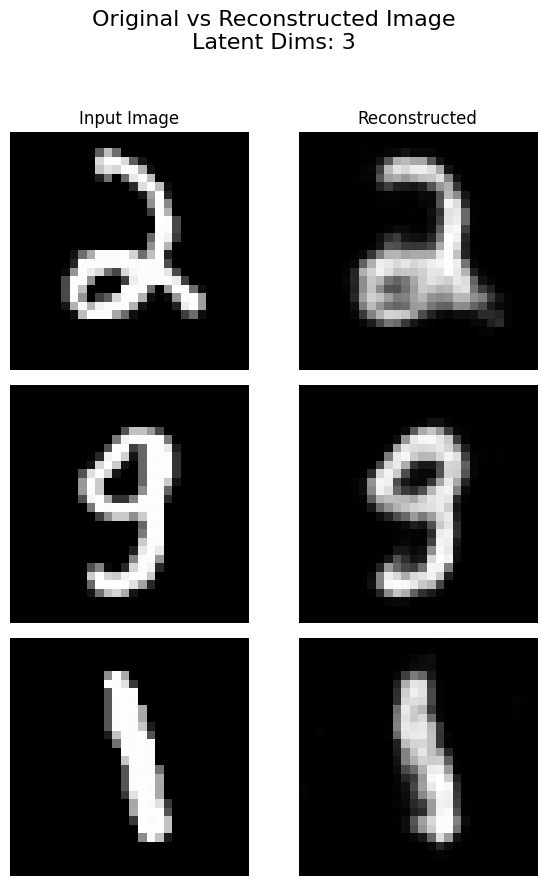

In [15]:
# Validate the model
num_samples = 3
fig, axs = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))
fig.suptitle('Original vs Reconstructed Image\nLatent Dims: 3', fontsize=16)

for i in range(num_samples):
    # Get a random image from the validation dataset
    idx = np.random.randint(len(val_ds))
    image, _ = val_ds[idx]
    pred_image = model(image[None])[0]

    # Plot the original image in the first column
    show(image[0], ax=axs[i, 0], title='Input Image' if i == 0 else "")
    # Plot the reconstructed image in the second column
    show(pred_image[0], ax=axs[i, 1], title='Reconstructed' if i == 0 else "")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout, leaving space for the suptitle
plt.show()

## Leveraging t-SNE (t-Distributed Stochastic Neighbor Embedding)

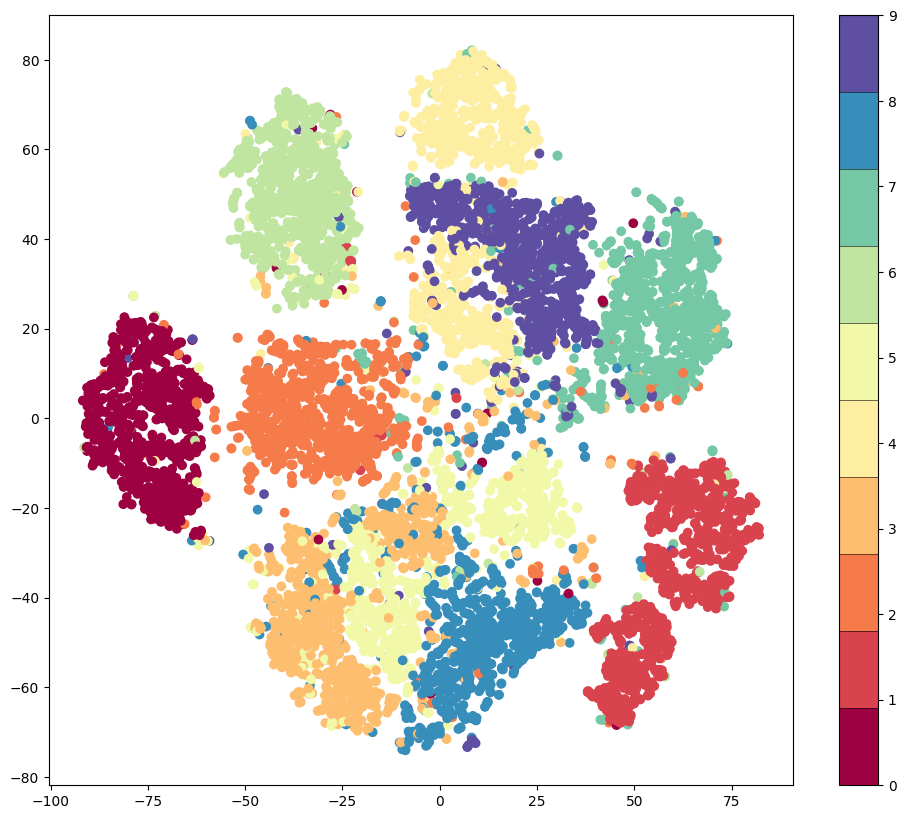

In [12]:
# Initialize latent vectors and classes
latent_vectors = []
classes = []

# Get latent vectors and classes for the validation dataset (Pass through the encoder)
for image, _class in val_dl:
    latent_vectors.append(model.encoder(image).view(len(image), -1))
    classes.extend(_class)

# Concatenate latent vectors and convert to numpy array
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

# Perform t-SNE on the latent vectors
tsne = TSNE()
clustered = tsne.fit_transform(latent_vectors)

# Plot the t-SNE results
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

### Variational Autoencoders and why we need them (Trying to generate numbers with the current architecture)

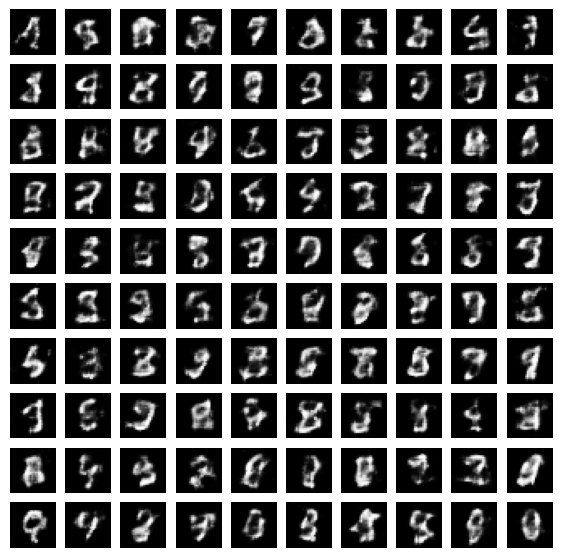

In [17]:
# Initialize latent vectors and classes
latent_vectors = []
classes = []

# Get latent vectors and classes for the validation dataset (Pass through the encoder)
for image, _class in val_dl:
    latent_vectors.append(model.encoder(image).view(len(image), -1))
    classes.extend(_class)

# Concatenate latent vectors and convert to numpy array
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

# Initialize a list to store random vectors
rand_vectors = []

# Generate random vectors for each column in the latent vectors
for col in latent_vectors.transpose(1, 0):
    mu, sigma = col.mean(), col.std() # Get the mean and standard deviation of the column
    rand_vec = (sigma * torch.randn(100) + mu).unsqueeze(1) # Multiply the standard deviation by a random number to add noise
    rand_vectors.append(rand_vec)

# Concatenate the random vectors and move to device
rand_vectors = torch.cat(rand_vectors, dim=1).to(device)

# Plot the random vectors
fig, ax = plt.subplots(10, 10, figsize=(7, 7))
ax = iter(ax.flat)
for p in rand_vectors:
    image = model.decoder(p.reshape(1, 64, 2, 2)).view(28,28) # Pass through the decoder
    show(image, ax=next(ax))